<a href="https://colab.research.google.com/github/NataliaKolesnik/Car_Price_prediction_part2/blob/master/2_CatBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.1 MB/s 


In [3]:
path_data = '/content/drive/MyDrive/SF_project_8/data/'

##Библиотеки

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error

from catboost import Pool, CatBoostRegressor
from catboost.utils import create_cd
from catboost.eval.catboost_evaluation import *
from catboost.eval.evaluation_result import *


In [5]:
pd.set_option('display.float_format', '{:.2f}'.format)

SEED = 42
np.random.seed(SEED)


## Загрузка и подготовка данных для обучения

In [6]:
df_train = pd.read_csv(path_data+'train_for_ML.csv')
df_test = pd.read_csv(path_data+'test_for_ML.csv')

In [7]:
df_train.columns

Index(['bodyType', 'brand', 'color', 'description', 'engineDisplacement',
       'enginePower', 'fuelType', 'mileage', 'model_info', 'numberOfDoors',
       'price', 'productionDate', 'sell_id', 'vehicleTransmission',
       'Владельцы', 'ПТС', 'Привод', 'brand_model', 'color_littel',
       'enginePower_log', 'fuelType_littel', 'mileage_стоп_q99', 'mileage_log',
       'age_avto', 'age_avto_стоп_23', 'mileage_/_age_avto', 'xDrive',
       'Владельцы_кат', 'ПТС_10', 'price_log'],
      dtype='object')

In [8]:
# Списки со всеми признаками

categorical_features_full = ['bodyType', 'brand', 'model_info', 'brand_model', 'color', 'color_littel',
                             'fuelType', 'fuelType_littel', 'vehicleTransmission', 'ПТС', 'Привод', 'Владельцы_кат']

numerical_features_full = ['engineDisplacement', 'enginePower', 'enginePower_log', 'mileage', 'mileage_стоп_q99',
                           'age_avto', 'age_avto_стоп_23', 'mileage_/_age_avto', 'productionDate', 'Владельцы',
                           'numberOfDoors', 'xDrive', 'ПТС_10']

In [9]:
# Стандартизируем числовые данные

df_test['price'] = 0
df_test['price_log'] = 0

df_train = df_train[categorical_features_full + numerical_features_full + ['price', 'price_log']]
df_test = df_test[categorical_features_full + numerical_features_full + ['price', 'price_log']]

df_train['sample'] = 1
df_test['sample'] = 0

df_joun = pd.concat([df_train, df_test])

scaler = MinMaxScaler()

df_joun[numerical_features_full] = scaler.fit_transform(df_joun[numerical_features_full])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [10]:
df_train = df_joun[df_joun['sample'] == 1].drop(['sample'], axis=1)
df_test = df_joun[df_joun['sample'] == 0].drop(['sample', 'price', 'price_log'], axis=1)

In [11]:
# Списки с признаками для обучения

target = 'price'
target_log = 'price_log'

categorical_features = ['bodyType', 'brand', 'model_info', 'color', 
                             'fuelType', 'vehicleTransmission', 'ПТС', 'Привод', 'Владельцы_кат']

numerical_features = ['engineDisplacement', 'enginePower_log', 'mileage', 
                           'age_avto', 'mileage_/_age_avto', 'productionDate', 
                           'numberOfDoors', 'xDrive',]

In [12]:
# Соберем датасеты

X = df_train[categorical_features + numerical_features]

X_test = df_test[categorical_features + numerical_features]

Y = df_train[target]
Y_log = df_train[target_log]

In [13]:
X.describe()

,Владельцы_кат,engineDisplacement,enginePower_log,mileage,age_avto,mileage_/_age_avto,productionDate,numberOfDoors,xDrive
count,6682.00,6682.00,6682.00,6682.00,6682.00,6682.00,6682.00,6682.00,6682.00
mean,2.09,0.42,0.51,0.12,0.21,0.17,0.79,0.76,0.11
std,0.83,0.16,0.17,0.08,0.13,0.09,0.13,0.29,0.32
min,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,1.00,0.30,0.40,0.06,0.11,0.12,0.71,0.67,0.00
50%,2.00,0.42,0.50,0.11,0.18,0.17,0.82,0.67,0.00
75%,3.00,0.45,0.63,0.17,0.29,0.22,0.89,1.00,0.00
max,3.00,1.00,0.96,1.00,1.00,1.00,1.00,1.00,1.00


In [14]:
X_test.describe()

,Владельцы_кат,engineDisplacement,enginePower_log,mileage,age_avto,mileage_/_age_avto,productionDate,numberOfDoors,xDrive
count,1671.00,1671.00,1671.00,1671.00,1671.00,1671.00,1671.00,1671.00,1671.00
mean,2.10,0.42,0.51,0.12,0.21,0.17,0.79,0.75,0.11
std,0.83,0.16,0.17,0.08,0.14,0.09,0.14,0.30,0.31
min,1.00,0.00,0.13,0.00,0.00,0.00,0.00,0.00,0.00
25%,1.00,0.30,0.40,0.06,0.11,0.11,0.71,0.67,0.00
50%,2.00,0.41,0.50,0.11,0.18,0.16,0.82,0.67,0.00
75%,3.00,0.45,0.63,0.17,0.29,0.22,0.89,1.00,0.00
max,3.00,1.00,1.00,1.00,1.00,0.76,1.00,1.00,1.00


In [15]:
# Разбиваем на обучающую и валидационную выборки

X_train_log, X_valid_log, Y_train_log, Y_valid_log = train_test_split(X, Y_log, test_size=0.2, random_state=SEED, shuffle=True)
X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, test_size=0.2, random_state=SEED, shuffle=True)

In [16]:
# Готовим pool для catboost

train_pool = Pool(X_train, Y_train, cat_features=categorical_features)
valid_pool = Pool(X_valid, Y_valid, cat_features=categorical_features)

train_pool_log = Pool(X_train_log, Y_train_log, cat_features=categorical_features)
valid_pool_log = Pool(X_valid_log, Y_valid_log, cat_features=categorical_features)


test_pool = Pool(X_test, cat_features=categorical_features)


## Обучение модели

In [17]:
# определим нашу функцию 
def MAPE(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

In [24]:
# создаем модель
model = CatBoostRegressor(
    #depth=8, 
    #l2_leaf_reg=0.3,
    #learning_rate=0.08, #0.03
    iterations=10000, 
    eval_metric='MAPE',
    custom_metric=['RMSE', 'MAE'],
    random_seed=SEED,
    # grow_policy='Depthwise',
    # score_function='L2'
    od_wait=500,
    #boosting_type='Ordered'
    )


In [25]:
# обучаем модель с сокращенными данными
model.fit(train_pool, 
          eval_set=valid_pool, 
          #logging_level='Silent', 
          verbose_eval=500,
          use_best_model=True,
          plot=False)

Learning rate set to 0.016262
0:	learn: 0.9863938	test: 1.0199176	best: 1.0199176 (0)	total: 15.4ms	remaining: 2m 34s
500:	learn: 0.1755756	test: 0.1791531	best: 0.1789713 (499)	total: 6.3s	remaining: 1m 59s
1000:	learn: 0.1561589	test: 0.1651816	best: 0.1651671 (998)	total: 12.7s	remaining: 1m 54s
1500:	learn: 0.1459580	test: 0.1605435	best: 0.1605435 (1500)	total: 19.8s	remaining: 1m 51s
2000:	learn: 0.1382178	test: 0.1569142	best: 0.1568968 (1981)	total: 26.4s	remaining: 1m 45s
2500:	learn: 0.1313437	test: 0.1522313	best: 0.1522193 (2498)	total: 33.1s	remaining: 1m 39s
3000:	learn: 0.1250682	test: 0.1481450	best: 0.1481447 (2998)	total: 39.7s	remaining: 1m 32s
3500:	learn: 0.1200977	test: 0.1462643	best: 0.1462643 (3500)	total: 49s	remaining: 1m 31s
4000:	learn: 0.1159598	test: 0.1451031	best: 0.1451001 (3999)	total: 56.7s	remaining: 1m 25s
4500:	learn: 0.1121837	test: 0.1439685	best: 0.1439547 (4499)	total: 1m 3s	remaining: 1m 17s
5000:	learn: 0.1090285	test: 0.1432887	best: 0.1432

In [26]:
model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,enginePower_log,15.70
1,engineDisplacement,15.39
2,mileage,14.31
3,age_avto,12.59
4,productionDate,10.59
5,mileage_/_age_avto,7.65
6,model_info,5.91
7,brand,4.53
8,bodyType,3.80
9,Привод,3.39


In [27]:
model_log = CatBoostRegressor(
    #depth=8, 
    #l2_leaf_reg=0.3,
    #learning_rate=0.08, #0.03
    iterations=10000, 
    eval_metric='MAPE',
    custom_metric=['RMSE', 'MAE'],
    random_seed=SEED,
    # grow_policy='Depthwise',
    # score_function='L2'
    od_wait=500,
    #boosting_type='Ordered'
    )


In [28]:
# обучаем модель с не сокращенными данными
model_log.fit(train_pool_log, 
          eval_set=valid_pool_log, 
          #logging_level='Silent', 
          verbose_eval=500,
          use_best_model=True,
          plot=False)

Learning rate set to 0.016262
0:	learn: 0.0419572	test: 0.0427332	best: 0.0427332 (0)	total: 16.4ms	remaining: 2m 43s
500:	learn: 0.0099278	test: 0.0098648	best: 0.0098648 (500)	total: 6.47s	remaining: 2m 2s
1000:	learn: 0.0088877	test: 0.0093144	best: 0.0093144 (1000)	total: 13s	remaining: 1m 57s
1500:	learn: 0.0082296	test: 0.0089972	best: 0.0089972 (1500)	total: 19.6s	remaining: 1m 51s
2000:	learn: 0.0078140	test: 0.0088493	best: 0.0088492 (1994)	total: 26.4s	remaining: 1m 45s
2500:	learn: 0.0074518	test: 0.0087109	best: 0.0087109 (2500)	total: 33.2s	remaining: 1m 39s
3000:	learn: 0.0071736	test: 0.0086343	best: 0.0086342 (2999)	total: 39.9s	remaining: 1m 33s
3500:	learn: 0.0069165	test: 0.0085764	best: 0.0085764 (3500)	total: 46.8s	remaining: 1m 26s
4000:	learn: 0.0066825	test: 0.0085389	best: 0.0085375 (3941)	total: 53.7s	remaining: 1m 20s
4500:	learn: 0.0064704	test: 0.0085129	best: 0.0085129 (4500)	total: 1m	remaining: 1m 14s
5000:	learn: 0.0062834	test: 0.0084978	best: 0.008497

In [29]:
model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,enginePower_log,15.70
1,engineDisplacement,15.39
2,mileage,14.31
3,age_avto,12.59
4,productionDate,10.59
5,mileage_/_age_avto,7.65
6,model_info,5.91
7,brand,4.53
8,bodyType,3.80
9,Привод,3.39


### Проверка влияние признака на результат

In [47]:
train_df = pd.concat([Y_train, X_train], axis=1)
valid_df = pd.concat([Y_valid, X_valid], axis=1)                    


train_df.to_csv(os.path.join(path_data, 'train.tsv'), 
                index=False, sep='\t', header=False)


valid_df.to_csv(os.path.join(path_data, 'valid.tsv'), 
              index=False, sep='\t', header=False)



feature_names = dict()

for column, name in enumerate(train_df):
    if column == 0:
        continue
    feature_names[column-1] = name
    

create_cd(
    label=0,
    cat_features=list(range(1, 10)),
    feature_names=feature_names,
    output_path=os.path.join(path_data, 'train.cd')
)

In [48]:
!cat /content/drive/MyDrive/SF_project_8/data/train.cd

0	Label	
1	Categ	bodyType
2	Categ	brand
3	Categ	model_info
4	Categ	color
5	Categ	fuelType
6	Categ	vehicleTransmission
7	Categ	ПТС
8	Categ	Привод
9	Categ	Владельцы_кат
10	Num	engineDisplacement
11	Num	enginePower_log
12	Num	mileage
13	Num	age_avto
14	Num	mileage_/_age_avto
15	Num	productionDate
16	Num	numberOfDoors
17	Num	xDrive


In [51]:
# Запускаем проверку

learn_params= {
    #'depth': 8, 
    'l2_leaf_reg': 0.3,
    'learning_rate': 0.08, #0.03
    'iterations': 3000, 
    'loss_function': 'RMSE', 
    'random_seed': SEED,
    'od_wait':500,
    'boosting_type':'Ordered',
    'verbose': False
}

evaluator = CatboostEvaluation(
    path_data+'train.tsv',
    fold_size=train_df.shape[0]//4,
    fold_count=6,
    column_description=path_data+'train.cd',
    partition_random_seed=SEED
)

result=evaluator.eval_features(learn_config=learn_params,
                               eval_metrics=['MAPE'],
                               features_to_eval=[0,1,2,3,4,5,6,7,9,11,12,13,14,15,16])

In [52]:

MAPE_result=result.get_metric_results('MAPE')
MAPE_result.get_baseline_comparison(
    ScoreConfig(ScoreType.Rel, overfit_iterations_info=False)
)

,PValue,Score,Quantile 0.005,Quantile 0.995,Decision
Features: 12,0.03,47.68,46.07,49.28,UNKNOWN
Features: 14,0.03,47.12,45.32,49.23,UNKNOWN
Features: 11,0.03,31.79,29.67,34.19,UNKNOWN
Features: 9,0.03,20.51,15.96,25.26,UNKNOWN
Features: 2,0.03,9.97,7.14,12.09,UNKNOWN
Features: 4,0.03,7.28,3.10,10.05,UNKNOWN
Features: 1,0.06,7.22,1.97,10.68,UNKNOWN
Features: 13,0.03,6.08,2.57,9.53,UNKNOWN
Features: 15,0.06,3.37,-1.01,6.57,UNKNOWN
Features: 6,0.03,2.35,0.50,5.23,UNKNOWN


In [30]:
# Проверка предсказания на вилидационных данных
y_valid_predict = model.predict(valid_pool)

MAPE(Y_valid, y_valid_predict)

0.14189427590724124

In [38]:
# Проверка предсказания на вилидационных данных
y_valid_predict_log = model_log.predict(valid_pool_log)
y_valid_predict_log = np.exp(y_valid_predict_log) 
MAPE(Y_valid, y_valid_predict_log)

0.12205083569591083

## Предсказание

In [39]:
# предсказываем результат 
y_test_predict = model_log.predict(test_pool)

In [40]:
y_test_predict

array([13.31664167, 14.68947929, 13.37583592, ..., 14.27171455,
       13.98315761, 13.92815097])

In [41]:
y_test_predict = np.exp(y_test_predict)

In [42]:
submission = pd.read_csv(path_data+'sample_submission.csv')
submission['price'] = y_test_predict
submission.to_csv(path_data+'sample_submission_catboost.csv', index=False)

In [43]:
submission

,sell_id,price
0,1099427284,607217.10
1,1096405886,2396402.68
2,1100195294,644246.00
3,1099827282,468538.59
4,1100076198,2703694.50
...,...,...
1666,1099414488,1012890.84
1667,1099277058,2720231.72
1668,1098773964,1578072.22
1669,1098835932,1182519.17


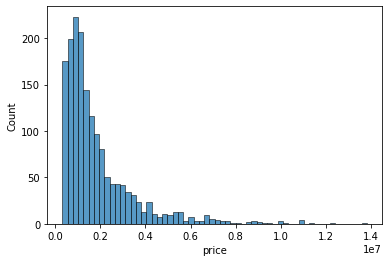

In [44]:
sns.histplot(submission['price'])